In [ ]:
'''
TODO:
dependincies smokiing vs Hx
compare age to savrity of cancer - Stage
age-smoking
Outliers: test features combined with Agehttps://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook
compare gender on each feature
add plot from paper - done
read paper
check which categries can be converted to numbers (like stage) - should use one hot encoding
deal which classes that have low numbers of participants (like stage >3)
'''

**IMPORTS**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


*The Dataframe*

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_folder_path = '/content/drive/My Drive/tables_data'
os.chdir(shared_folder_path)
df = pd.read_csv('Thyroid_Dataset.csv')

Mounted at /content/drive


                                                                      Data Analysis And Visualization

In [ ]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


*Skew*

TODO: relevat only for Age(?) should covert all claess to numeric for calculate skew(?) video 4 20 last mins, just mentioned shorlty




In [ ]:
df.skew()

Age    0.719732
dtype: float64

Age is positive skewed

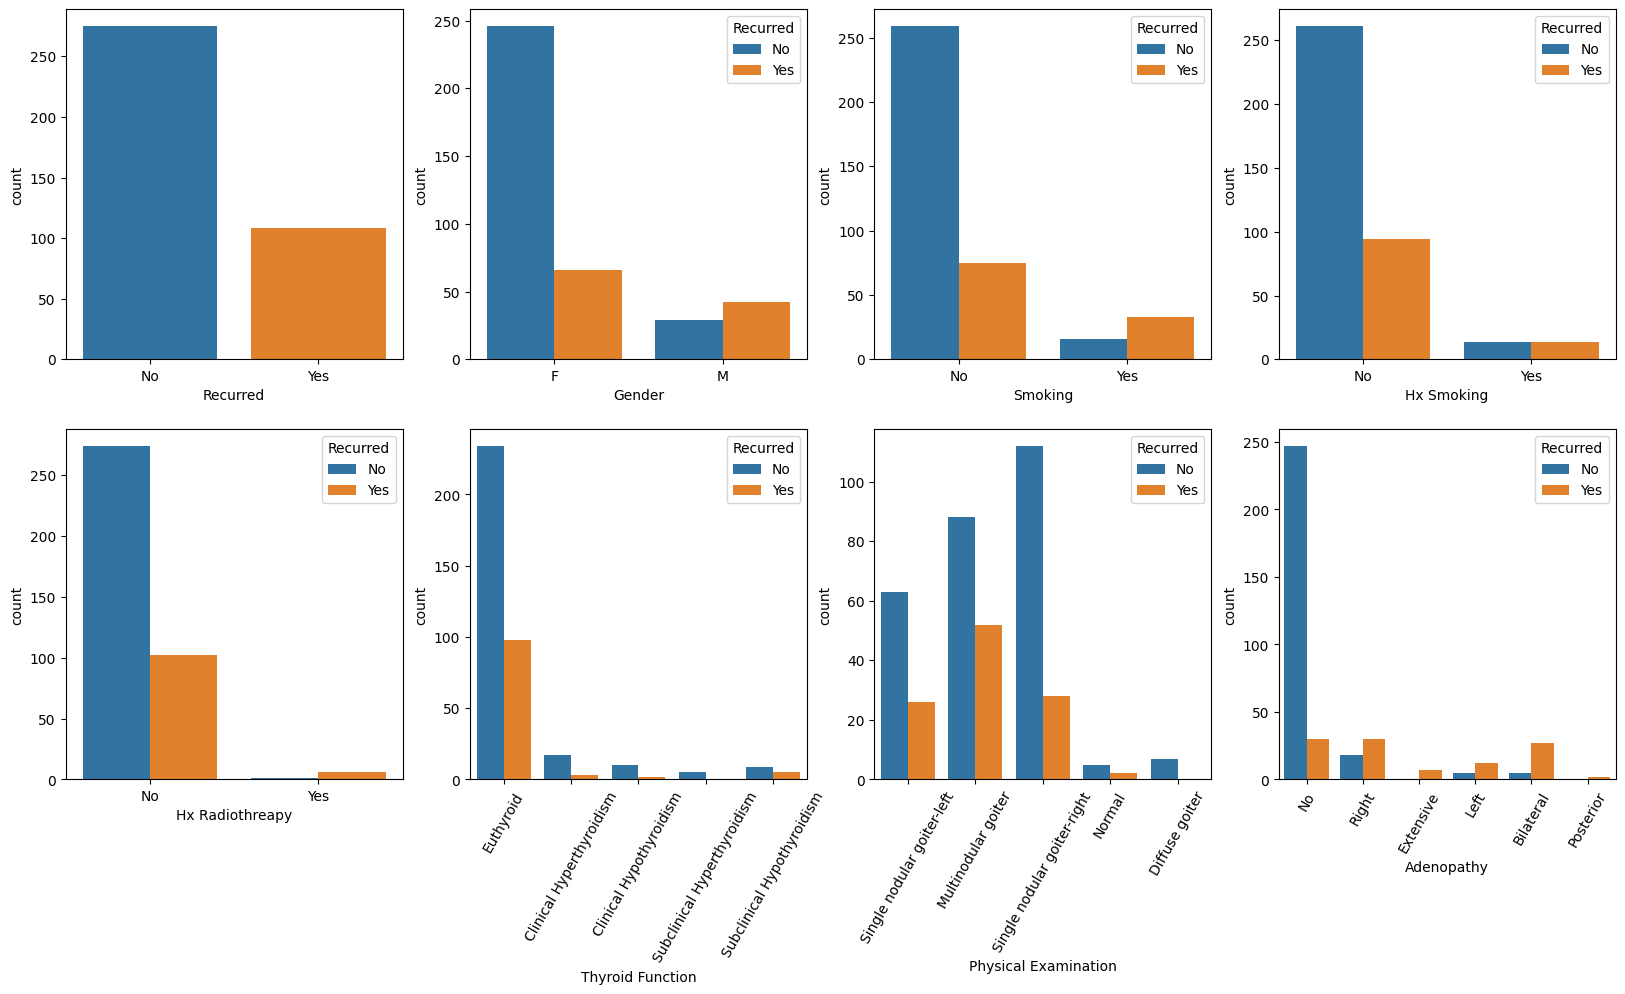

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(241)
sns.countplot(df, x='Recurred', hue='Recurred')
plt.subplot(242)
sns.countplot(df, x='Gender', hue='Recurred')
plt.subplot(243)
sns.countplot(df, x='Smoking', hue='Recurred')
plt.subplot(244)
sns.countplot(df, x='Hx Smoking', hue='Recurred')
plt.subplot(245)
sns.countplot(df, x='Hx Radiothreapy', hue ='Recurred')
plt.subplot(246)
sns.countplot(df, x='Thyroid Function', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(247)
sns.countplot(df, x='Physical Examination', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(248)
sns.countplot(df, x='Adenopathy', hue='Recurred')
plt.xticks(rotation=60)
plt.show()

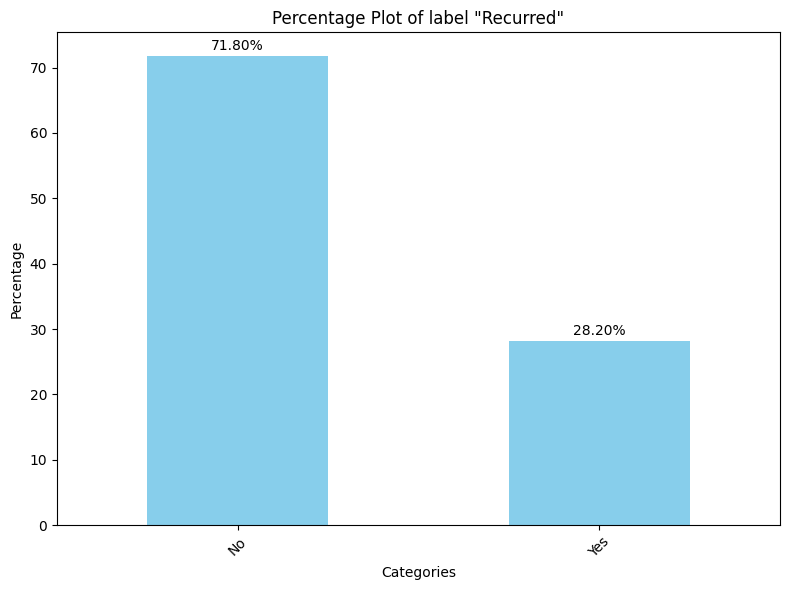

In [ ]:
# Calculate the percentage values
percentages = df['Recurred'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
percentages.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Percentage Plot of label "Recurred"')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the percentage values on the bars
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

 We observe from the plot that approximately 71.8% of individuals in the dataset are predicted not to experience cancer recurrence. Given this baseline prediction accuracy, we would recommend deploying a machine learning model for prediction purposes only if its accuracy exceeds 72%. Should the model's accuracy fall below this threshold, an alternative approach, such as a simple coin flip, may yield comparable or superior results, thus warranting consideration as an alternative predictive strategy.

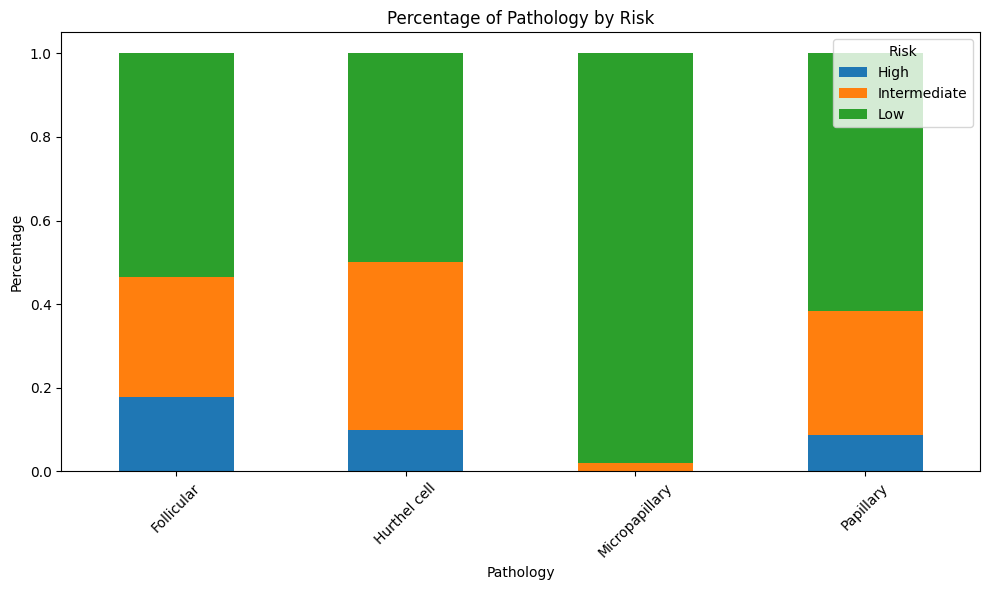

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Calculate percentages
total_counts = df.groupby('Pathology').size()
grouped_counts = df.groupby(['Pathology', 'Risk']).size()
percentages = (grouped_counts / total_counts).unstack(fill_value=0)

# Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Percentage of Pathology by Risk')
plt.xlabel('Pathology')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Risk')
plt.tight_layout()
plt.show()

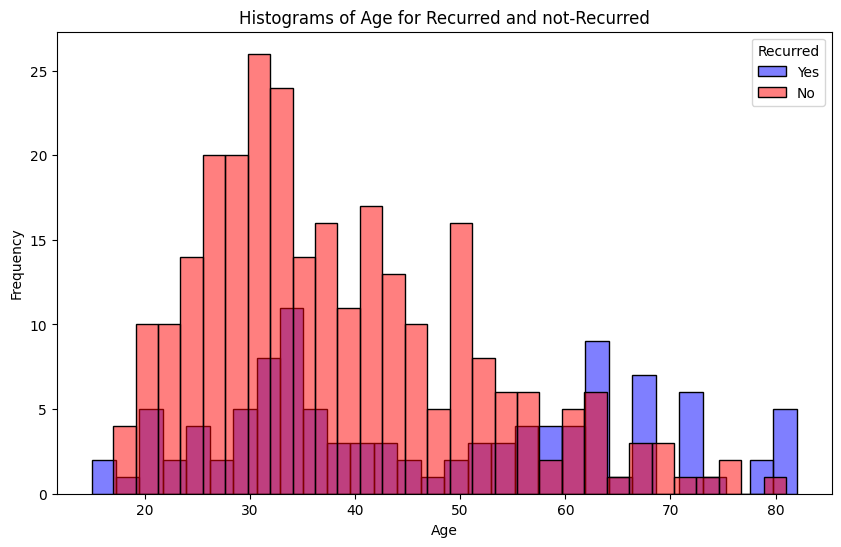

In [ ]:

df_y = df[df['Recurred'] == 'Yes']
df_n = df[df['Recurred'] == 'No']

plt.figure(figsize=(10, 6))
sns.histplot(df_y['Age'], color='blue', label='Yes', bins=30, alpha=0.5)
sns.histplot(df_n['Age'], color='red', label='No', bins=30, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Recurred and not-Recurred')
plt.legend(title='Recurred')
plt.show()

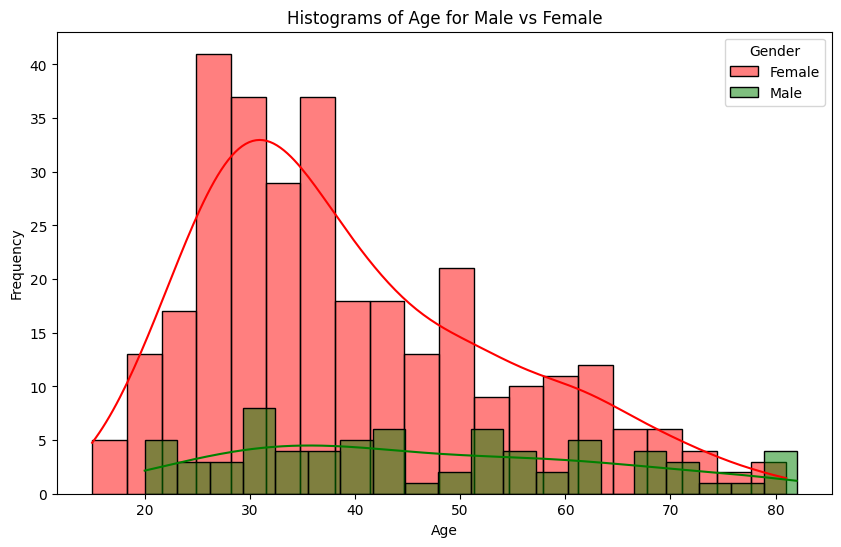

In [ ]:
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']

plt.figure(figsize=(10, 6))
sns.histplot(df_female['Age'], color='red', label='Female', kde=True, bins=20, alpha=0.5)
sns.histplot(df_male['Age'], color='green', label='Male', kde=True, bins=20, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Male vs Female')
plt.legend(title='Gender')
plt.show()

In addiotion to the skew value we claculted above, we can also see that  gender and age distribution is positive skewed

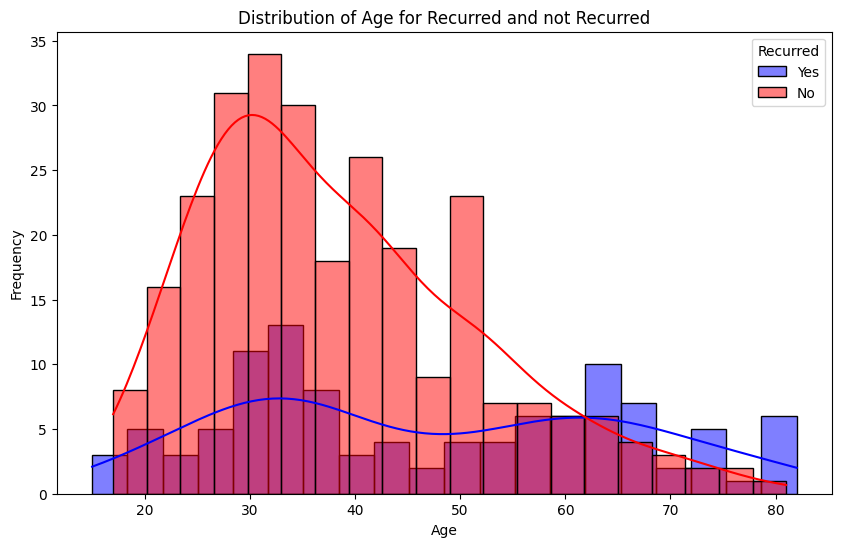

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for 'Y' label
sns.histplot(df[df['Recurred'] == 'Yes']['Age'], bins=20, kde=True, color='blue', label='Yes')

# Plot for 'N' label
sns.histplot(df[df['Recurred'] == 'No']['Age'], bins=20, kde=True, color='red', label='No')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Recurred and not Recurred')
plt.legend(title='Recurred')
plt.show()


Insight: from those results we can assume that high age might indicated on high probablity for reccuring

We can assume that there's a high correlation between Smoking and Hx Smoking, indicating that in this dataset, it's uncommon for a person to change their smoking status.



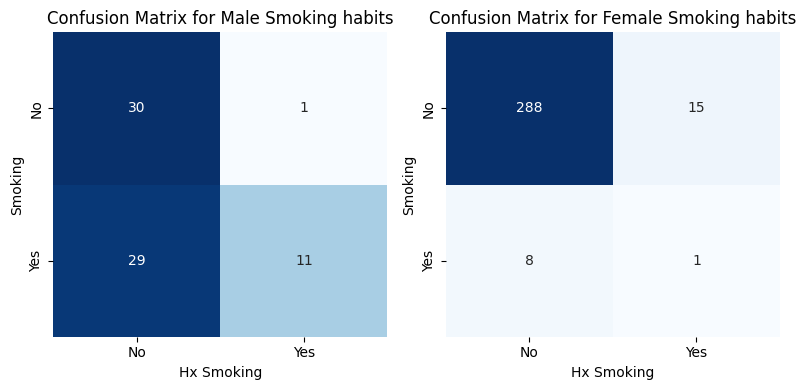

In [ ]:
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']

male_conf_matrix = pd.crosstab(male_df['Smoking'], male_df['Hx Smoking'])
female_conf_matrix = pd.crosstab(female_df['Smoking'], female_df['Hx Smoking'])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(male_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix for Male Smoking habits')
axs[0].set_xlabel('Hx Smoking')
axs[0].set_ylabel('Smoking')

sns.heatmap(female_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix for Female Smoking habits')
axs[1].set_xlabel('Hx Smoking')
axs[1].set_ylabel('Smoking')

plt.tight_layout()
plt.show()

We can assume that for female there's high correltion in Smoking and Hx Smoking so that in this dataset it's not common that a person changed her Smoking habits for men we can see lower corrletion and more changings in Smoking habits.


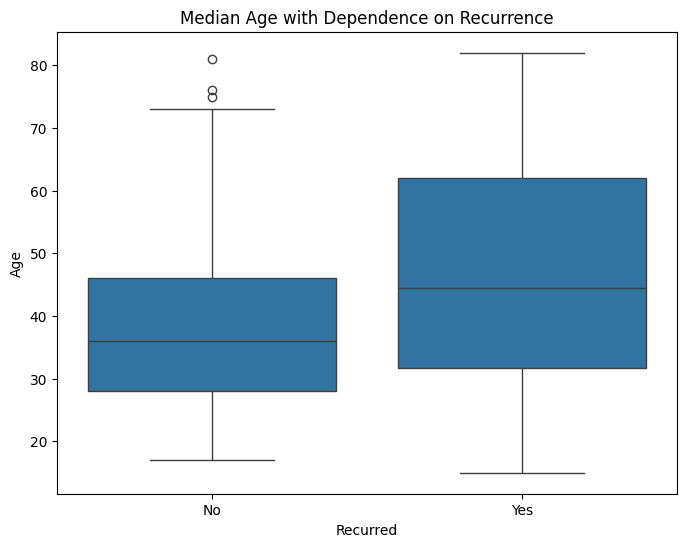

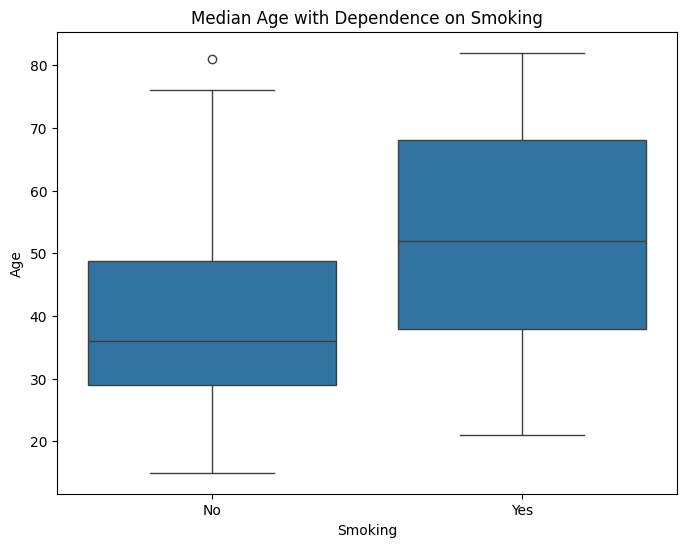

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Recurred', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Recurrence')
plt.xlabel('Recurred')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoking', y='Age', data=df)

# Add labels and title
plt.title('Median Age with Dependence on Smoking')
plt.xlabel('Smoking')
plt.ylabel('Age')

# Show plot
plt.show()

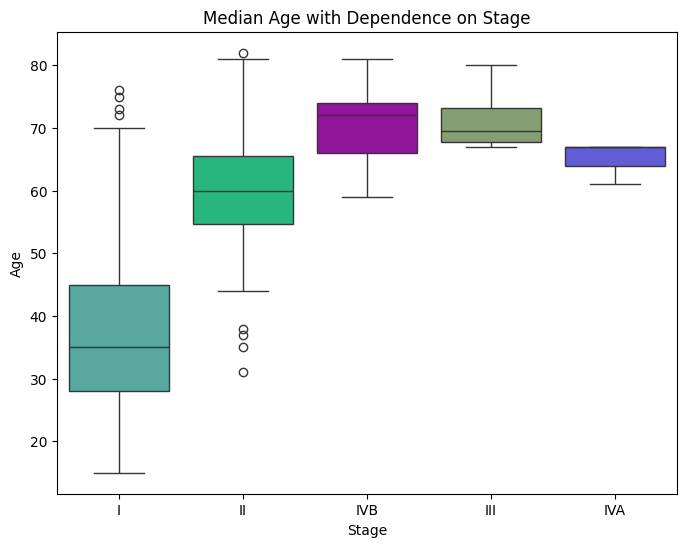

Number of rows where Stage is IVb: 3
Number of rows where Stage is IVb and Recurred is Yes: 3


In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(df)

# Get unique stages
stages = df['Stage'].unique()

# Generate random colors
color_map = {stage: np.random.rand(3,) for stage in stages}

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stage', y='Age', data=df, palette=color_map)

# Add labels and title
plt.title('Median Age with Dependence on Stage')
plt.xlabel('Stage')
plt.ylabel('Age')

# Show plot
plt.show()

# Convert data to DataFrame
df = pd.DataFrame(df)
stage_IVb_df = df[df['Stage'] == 'IVA']

# Count the number of rows where Recurred is Yes
recurred_yes_count = stage_IVb_df[stage_IVb_df['Recurred'] == 'Yes'].shape[0]

# Total number of rows where Stage is IVb
total_IVb_count = stage_IVb_df.shape[0]

print("Number of rows where Stage is IVb:", total_IVb_count)
print("Number of rows where Stage is IVb and Recurred is Yes:", recurred_yes_count)

*XGBOOST Model*

In [33]:
'''
based on the example
https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/
'''

X = df.drop(columns=['Recurred'])
y = df['Recurred']

# adapt categorial classes
label_encoders = {}
for feature in X.select_dtypes(include=['object']).columns:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
y = y.replace({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


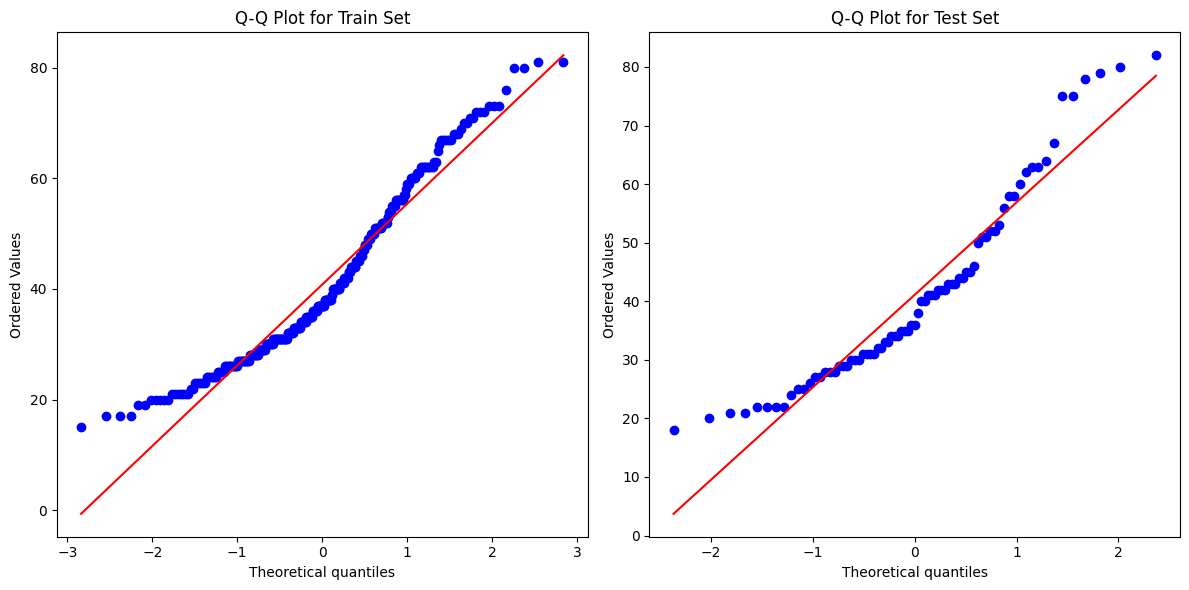

In [35]:
import scipy.stats as stats

import scipy.stats as stats

# Calculate quantiles for normal distribution
train_quantiles = np.linspace(0, 1, len(X_train))
test_quantiles = np.linspace(0, 1, len(X_test))

# Get quantiles for actual data
train_quantile_values = np.quantile(X_train['Age'], train_quantiles)
test_quantile_values = np.quantile(X_test['Age'], test_quantiles)

# Create Q-Q plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(X_train['Age'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Train Set')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')

plt.subplot(1, 2, 2)
stats.probplot(X_test['Age'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Test Set')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Accuracy is: 0.935064935064935
An example for one of the trees that the model uses:


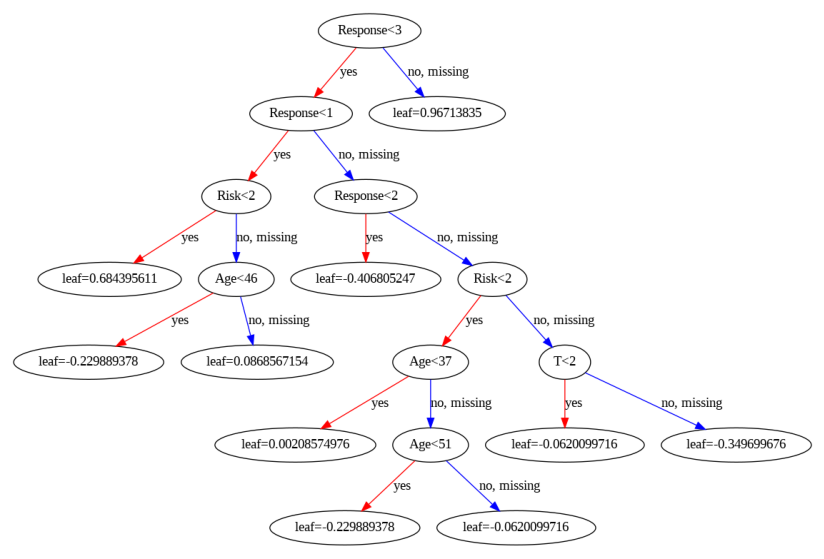

In [34]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy is:", accuracy)

#an example for a tree
print("An example for one of the trees that the model uses:")
plot_tree(model, num_trees=0, ax=plt.figure(figsize=(12, 7)).add_subplot())
plt.show()

show corrletion - rccurened vs stage (for each stage)

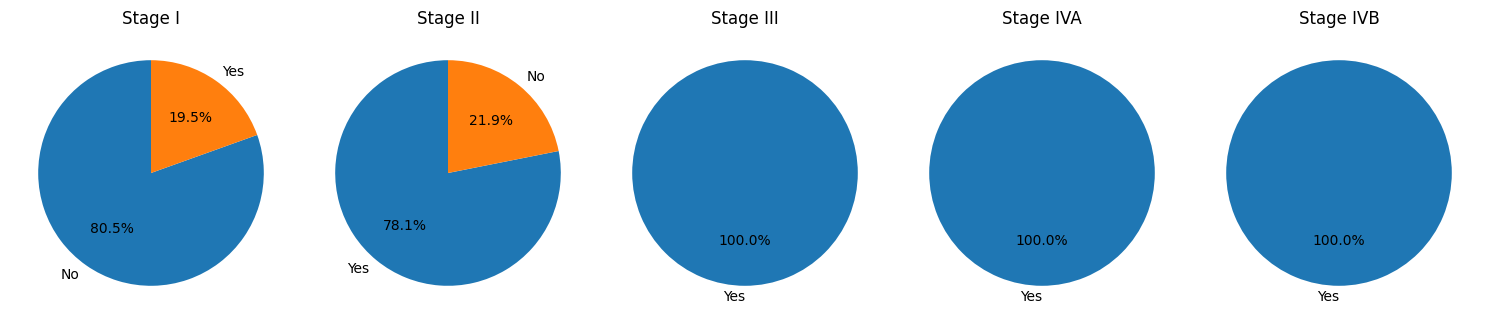

In [ ]:
unique_stages = sorted(df['Stage'].unique())

fig, axs = plt.subplots(1, len(unique_stages), figsize=(15, 5))

for i, stage in enumerate(unique_stages):
    stage_df = df[df['Stage'] == stage]

    counts = stage_df['Recurred'].value_counts()

    axs[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f"Stage {stage}")

plt.tight_layout()
plt.show()

For high stages, the 'Recurred' feature exhibits a homogeneous distribution, with only one class present.

*Correlation Heatmap*

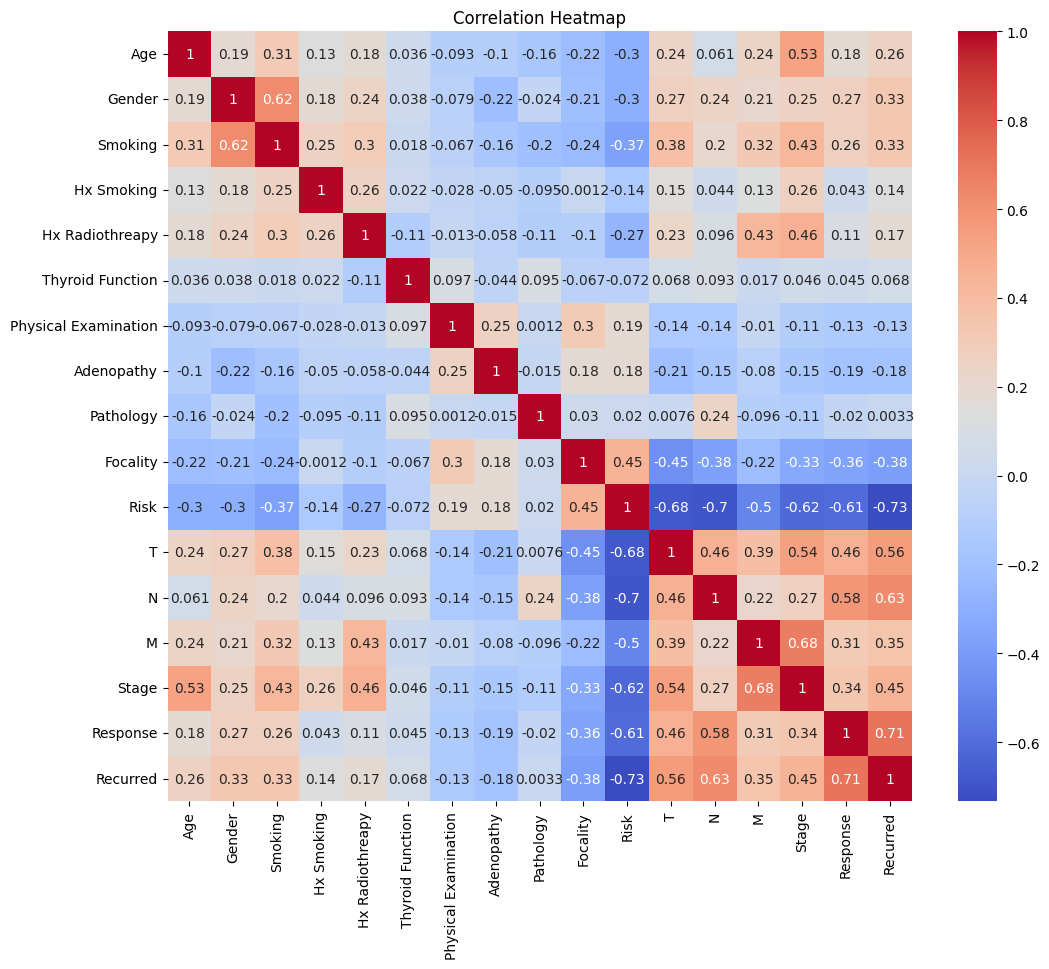

In [ ]:
# Create the heatmap
# adapt categorial classes
categorical_columns = df.select_dtypes(include=['object']).columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_columns:
  df[col] = le.fit_transform(df[col])
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

It's noted that there is a high correlation between Risk and Stage. However, apart from this correlation, there are no other notable high correlations among the features in the dataset.

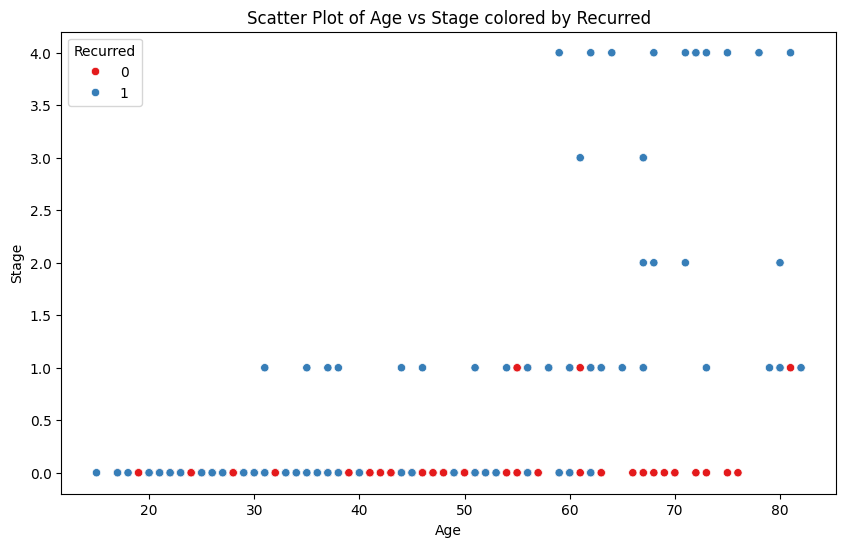

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Stage', hue='Recurred', data=df, palette='Set1')
plt.xlabel('Age')
plt.ylabel('Stage')
plt.title('Scatter Plot of Age vs Stage colored by Recurred')
plt.show()

Based on our analysis using two features from the dataset, we were unable to find a clear separation between the domains that align with the correct labels.

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df, x='Age', y='Thyroid Function', z='Physical Examination', color='Recurred',
                     symbol='Recurred', opacity=0.7, size_max=10)
fig.update_layout(title='3D Scatter Plot of Age, Stage, and Smoking colored by Recurred',
                  scene=dict(xaxis_title='Age', yaxis_title='Stage', zaxis_title='Risk'))
fig.show()


After analyzing the correlation heatmap, we aimed to investigate if there are any outliers in the dataset, particularly focusing on the three features that are scored as minimum. The heatmap indicated the presence of outliers. Considering this, we concluded that an SVM classifier model would be the most suitable approach to address this issue

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob